# autoencoder with denosie

> - autoencoder는 손실압축이다.
- 손실압축이기 때문에 노이즈가 제거되는 효과가 있다. 
- 원본이 중요한 압축에는 쓸 수 없다
- 하지만 mp3, image 등의 압축에는 쓸 수 있다.
- autoencoder는 느리고 손실압축되기 때문에 실제 압축 용도로는 쓰지 않는다.

In [22]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
# 타입 변환
# 스케일링

X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

X_train = X_train[...,np.newaxis]
X_test = X_test[...,np.newaxis]

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
# 노이즈 추가
# 노이즈는 랜덤해야한다.
# 랜덤하지 않으면 고유한 특성으로 인식하기 떄문에 차원이 줄어도 보존될 것이다.

noise_factor = 0.5
X_train_noisy = X_train + noise_factor *np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor *np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [10]:
# 스케일 맞추기 (0~1)

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

### cnn autoencoder with denoise

In [23]:
input_data = Input((28,28,1))
encoded = Conv2D(128, (3,3), padding="same")(input_data)
encoded = MaxPooling2D((2,2), padding="same")(encoded)
encoded = Conv2D(64, (3,3), padding="same")(encoded)
encoded = MaxPooling2D((2,2), padding="same")(encoded)
encoded = Conv2D(16, (3,3), padding="same")(encoded)
encoded = MaxPooling2D((2,2), padding="same")(encoded)

decoded = Conv2D(16, (3,3), padding="same")(encoded) # stacked 방식!
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(64, (3,3), padding="same")(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(128, (3,3))(decoded)  # padding="same"을 빼줘야 한다.
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(1, (3,3), padding="same")(decoded) # input과 output을 맞춰주는 역할을 함. (channel=1)

autoencoder = Model(input_data, decoded, name="autoencoder")

In [24]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 16)          9232      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 16)          

In [26]:
autoencoder.compile(loss="mse", optimizer="adam")

In [ ]:
# X_train으로 학습해도 될 것 같아서 X_train으로 해봤다.
# 어차피 차원이 축소되었다가 복구되는데 noise가 날라가지 않을까했다.
# 결과물을 보면 노이즈가 그대로 복구된 거 같은 느낌이 있다..
# X_train_noisy로 학습하는게 맞는 거 같다;
# 아래 dnn으로 할 때는 X_train_noisy로 학습함

histoy = autoencoder.fit(X_train, X_train, batch_size=32*4, epochs=5)

In [ ]:
def compare(data, model):
    predictions = model.predict(data)
    for x, pred in zip(data, predictions):
        
        x = x.reshape(28,28)
        pred = pred.reshape(28,28)
        
        plt.figure(figsize=(8,4))
        ax1 = plt.subplot(1,2,1)
        ax1.imshow(pred)
        ax1.set_title("predictied")

        ax2 = plt.subplot(1,2,2)
        ax2.imshow(x)
        ax2.set_title("origin")

        plt.show()

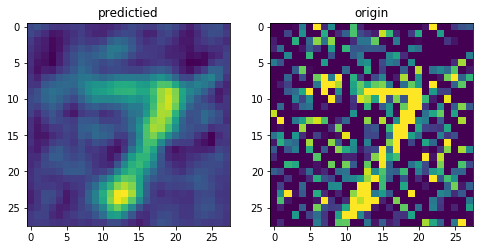

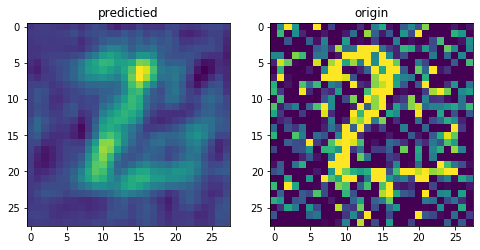

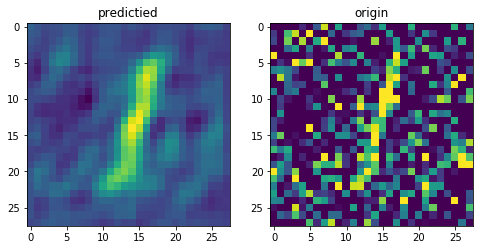

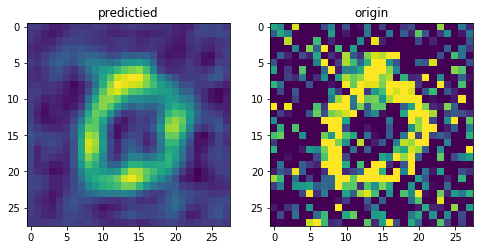

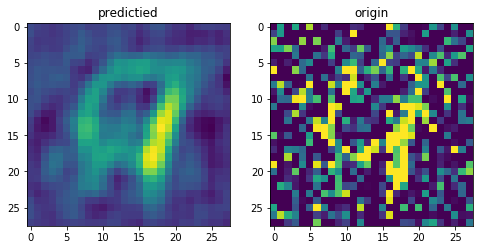

In [206]:
# X_train으로 학습했을 때

compare(X_test_noisy[:5], autoencoder)

### dnn autoencoder with denoise

In [75]:
layer1 = Dense(128, activation="relu", input_shape=(784,))
layer2 = Dense(64, activation="relu")
layer3 = Dense(32, activation="relu")
layer4 = Dense(16, activation="relu")
layer5 = Dense(8)

seq1 = Sequential([layer1, layer2, layer3, layer4, layer5], name="seq1")

layer6 = Dense(16, activation="relu")
layer7 = Dense(32, activation="relu")
layer8 = Dense(64, activation="relu")
layer9 = Dense(128, activation="relu")
layer10 = Dense(784, activation="sigmoid")
seq2 = Sequential([layer6, layer7, layer8, layer9, layer10], name="seq2")

seq3 = Sequential(name="seq3")
seq3.add(seq1)
seq3.add(seq2)

seq3.summary()

Model: "seq3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq1 (Sequential)            (None, 8)                 111480    
_________________________________________________________________
seq2 (Sequential)            (None, 784)               112256    
Total params: 223,736
Trainable params: 223,736
Non-trainable params: 0
_________________________________________________________________


In [76]:
seq3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [77]:
history2 = seq3.fit(X_train_noisy.reshape(-1,28*28), X_train.reshape(-1,28*28), epochs=10, batch_size=64)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 83us/sample - loss: 0.2436 - acc: 0.7937
Epoch 2/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.1937 - acc: 0.7965
Epoch 3/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.1736 - acc: 0.8000
Epoch 4/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.1667 - acc: 0.8012
Epoch 5/10
60000/60000 [==============================] - 5s 75us/sample - loss: 0.1607 - acc: 0.8025
Epoch 6/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.1545 - acc: 0.8039
Epoch 7/10
60000/60000 [==============================] - 5s 76us/sample - loss: 0.1516 - acc: 0.8044
Epoch 8/10
60000/60000 [==============================] - 5s 82us/sample - loss: 0.1496 - acc: 0.8048
Epoch 9/10
60000/60000 [==============================] - 5s 84us/sample - loss: 0.1481 - acc: 0.8050
Epoch 10/10
60000/60000 [==============================] - 

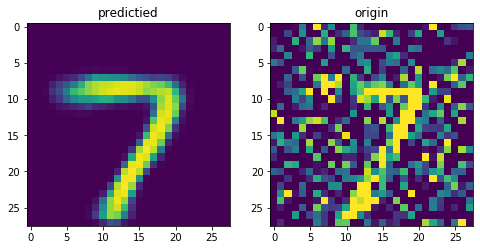

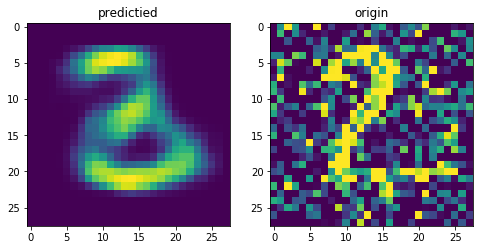

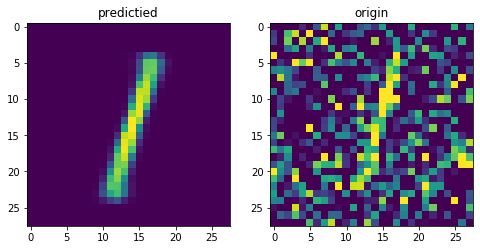

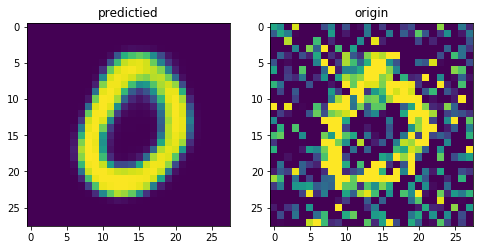

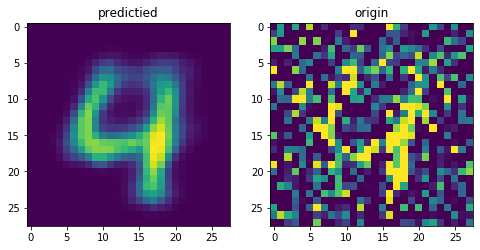

In [205]:
compare(X_test_noisy.reshape(-1,28*28)[:5], seq3)

> - noise가 없어졌다!

# Merge Layers

In [45]:
from tensorflow.keras.layers import Add, Lambda, Input

In [44]:
# Error!

layer1 = Dense(2, input_shape=(2,2), kernel_initializer="ones")
layer2 = Dense(2, input_shape=(2,2), kernel_initializer="ones")
layer3 = Add()

model = Sequential([layer1, layer2, layer3])

ValueError: A merge layer should be called on a list of inputs.

> - Add는 multi input layer이기 때문에 Sequential로 할 수 없다. 
- Model을 써야한다(함수형 패러다임)

In [66]:
inp = Input(shape=(2,2))
layer1 = Dense(2, kernel_initializer="ones")(inp)
layer2 = Dense(2, kernel_initializer="ones")(inp)
layer3 = Add()([layer1, layer2])

model = Model(inp, layer3)

In [67]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 2, 2)]       0                                            
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 2, 2)         6           input_8[0][0]                    
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 2, 2)         6           input_8[0][0]                    
__________________________________________________________________________________________________
add_4 (Add)                     (None, 2, 2)         0           dense_44[0][0]                   
                                                                 dense_45[0][0]             

In [64]:
x = np.array([[1,2],[3,4]])

In [65]:
model.predict(x[np.newaxis])

array([[[ 6.,  6.],
        [14., 14.]]], dtype=float32)

> - layer1 과 layer2를 통과한 결과를 서로 더했다.

In [53]:
Dense(2, kernel_initializer="ones")(x)

<tf.Tensor: id=52864, shape=(2, 2), dtype=float32, numpy=
array([[3., 3.],
       [7., 7.]], dtype=float32)>

> - layer1과 layer2의 결과는 위와 같다.
 - Dense가 2차원이면 행끼리 full connect한다.
 - param이 6인 이유는 bias가 포함이기 때문이다.

In [61]:
Dense(2, kernel_initializer="ones", use_bias=False)(x)

<tf.Tensor: id=53225, shape=(2, 2), dtype=float32, numpy=
array([[3., 3.],
       [7., 7.]], dtype=float32)>

> - `use_bias=False`하면 bias를 안 써서 param 수가 줄어든다. 
- 근데 `bias_initializer=zeros` 이기 때문에 bias는 0인 상태이다.

### Average layer

In [54]:
from tensorflow.keras.layers import Average

In [55]:
inp = Input(shape=(2,2))
layer1 = Dense(2, kernel_initializer="ones")(inp)
layer2 = Dense(2, kernel_initializer="ones")(inp)
layer3 = Average()([layer1, layer2])

model = Model(inp, layer3)

In [56]:
model.predict(x[np.newaxis])

array([[[3., 3.],
        [7., 7.]]], dtype=float32)

### Concatenate layer

In [58]:
from tensorflow.keras.layers import Concatenate

In [59]:
inp = Input(shape=(2,2))
layer1 = Dense(2, kernel_initializer="ones")(inp)
layer2 = Dense(2, kernel_initializer="ones")(inp)
layer3 = Concatenate()([layer1, layer2])

model = Model(inp, layer3)

In [60]:
model.predict(x[np.newaxis])

array([[[3., 3., 3., 3.],
        [7., 7., 7., 7.]]], dtype=float32)

> - 기본 옵션 `axis=-1`
- 2차원이면 열로 붙여준다(axis=1)

### Lambda layer
- lambda는 보통 함수형 패러다임에서 함수를 첫번째 인자로 넣을 때 많이 쓴다.
- lambda는 메모리에 남지 않는다. def는 메모리에 남는다.
- Keras의 Lambda layer는 함수를 인자로 받아서 값을 바꾸고 다음 레이어로 넘겨준다.
- 개꿀 기능! (나만의 기법 적용 가능)

In [68]:
from tensorflow.keras.layers import Lambda

In [72]:
inp = Input(shape=(2,2))
layer1 = Dense(2, kernel_initializer="ones")(inp)
layer2 = Dense(2, kernel_initializer="ones")(inp)
layer3 = Lambda(lambda x: x[0] - x[1])([layer1, layer2]) # tensorflow를 쓰기 때문에 output_shape은 안 써도 된다.

model = Model(inp, layer3)

In [73]:
model.predict(x[np.newaxis])

array([[[0., 0.],
        [0., 0.]]], dtype=float32)

---

# 공식문서 보면서 VAE 파트 수업
https://blog.keras.io/building-autoencoders-in-keras.html

In [89]:
timesteps = 28
input_dim = 28
latent_dim = 2

batch_size = 64
original_dim = 28
intermediate_dim = 2

epochs = 5

In [90]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.models import Model

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

In [91]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [99]:
import tensorflow.keras.backend as K
epsilon_std = 0.5

In [101]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [102]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [103]:
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)v

> ### loss를 두개를 넣어본다.

In [107]:
def vae_loss(x, x_decoded_mean):
    xent_loss = K.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=[vae_loss, "binary_crossentropy"])

ValueError: When passing a list as loss, it should have one entry per model outputs. The model has 1 outputs, but you passed loss=[<function vae_loss at 0x000001A811F2B2F0>, 'binary_crossentropy']

> - 에러 메시지를 보면 모델 output이 1개인데 loss가 2개라서 안된다는 에러가 뜬다.  
- 모델의 output이 2개면 loss를 2개 쓸 수 있다는 말로 들린다!

# 임의로 output 2개, loss 2개인 모델 만들기

In [167]:
inp = Input(shape=(28,28))
layer1 = Dense(2, kernel_initializer="ones")(inp)
layer2 = Dense(2, kernel_initializer="ones")(inp)

layer1_1 = Dense(28)(layer1)
layer2_1 = Dense(28)(layer2)

test_model = Model(inp, [layer1_1, layer2_1])

In [168]:
test_model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
dense_72 (Dense)                (None, 28, 2)        58          input_21[0][0]                   
__________________________________________________________________________________________________
dense_73 (Dense)                (None, 28, 2)        58          input_21[0][0]                   
__________________________________________________________________________________________________
dense_74 (Dense)                (None, 28, 28)       84          dense_72[0][0]                   
___________________________________________________________________________________________

In [169]:
test_model.output

[<tf.Tensor 'dense_74/Identity:0' shape=(None, 28, 28) dtype=float32>,
 <tf.Tensor 'dense_75/Identity:0' shape=(None, 28, 28) dtype=float32>]

> - output 2개다

In [171]:
def custom_loss(x, pred):
    return (x-pred)**2

> - 임의로 만든 loss function

In [172]:
test_model.compile(loss=["binary_crossentropy", custom_loss], optimizer="adam")

In [173]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [177]:
hist = test_model.fit(x_train, [x_train, x_train], epochs=5, batch_size=10)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 150us/sample - loss: 1.5207 - dense_74_loss: 1.3952 - dense_75_loss: 0.1255
Epoch 2/5
60000/60000 [==============================] - 9s 142us/sample - loss: 1.3335 - dense_74_loss: 1.2943 - dense_75_loss: 0.0392
Epoch 3/5
60000/60000 [==============================] - 8s 139us/sample - loss: 1.3297 - dense_74_loss: 1.2907 - dense_75_loss: 0.0390
Epoch 4/5
60000/60000 [==============================] - 8s 140us/sample - loss: 1.3292 - dense_74_loss: 1.2903 - dense_75_loss: 0.0390
Epoch 5/5
60000/60000 [==============================] - 8s 141us/sample - loss: 1.3284 - dense_74_loss: 1.2894 - dense_75_loss: 0.0390


> - target을 2개 넣는다.

In [178]:
hist.history

{'loss': [1.5207356555759908,
  1.3335282769898573,
  1.329658805300792,
  1.329233331431945,
  1.3283538738886516],
 'dense_74_loss': [1.3952241, 1.2943007, 1.2906762, 1.290271, 1.2893974],
 'dense_75_loss': [0.12551329,
  0.03922694,
  0.038983237,
  0.038963698,
  0.03895868]}

> - 기본 loss가 1개 나오고,
- 지정한 loss가 각각 1개씩 나온다

In [194]:
for lt ,l1, l2 in zip(*hist.history.values()):
    print(f"{lt} (lt) = {l1+l2} (l1+l2)")
    print(lt == l1+l2)

1.5207356555759908 (lt) = 1.5207374095916748 (l1+l2)
False
1.3335282769898573 (lt) = 1.3335275650024414 (l1+l2)
False
1.329658805300792 (lt) = 1.3296594619750977 (l1+l2)
False
1.329233331431945 (lt) = 1.3292347192764282 (l1+l2)
False
1.3283538738886516 (lt) = 1.3283560276031494 (l1+l2)
False


> - loss는 각각의 loss에 대한 합인가보다.(근사값)

In [199]:
preds = test_model.predict(x_test[0][np.newaxis])

In [200]:
len(preds)

2

In [202]:
preds[0].shape, preds[1].shape

((1, 28, 28), (1, 28, 28))

> - input 1개에 대해서 output 2개가 나온다.

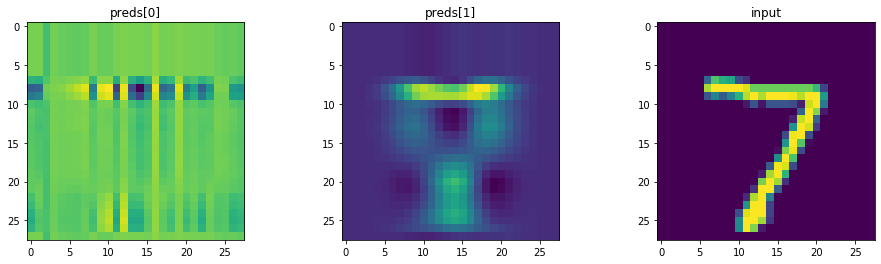

In [204]:
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1,3,1)
ax1.imshow(preds[0].squeeze())
ax1.set_title("preds[0]")

ax2 = plt.subplot(1,3,2)
ax2.imshow(preds[1].squeeze())
ax2.set_title("preds[1]")

ax3 = plt.subplot(1,3,3)
ax3.imshow(x_test[0])
ax3.set_title("input")

plt.show()

> - 각각 다른 loss fuction이 적용된 것 같다. 
- loss function만 다르게 하고 구조는 같은데, output 2개가 많이 다르다.
- 모델을 제대로 만들면 잘 나올 것 같다.